In [8]:
import cv2 as cv
import numpy as np
import mlflow
import dagshub
import os
import pathlib
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV
import pickle
from tqdm import tqdm
import seaborn as sns

In [2]:
PATH = pathlib.Path('C:\\Users\\vinar\\Downloads\\FER2013-augmented')
LABELS = os.listdir(PATH)

In [3]:
dagshub.init(repo_owner='IdjiotSandwiches', repo_name='face-emotion-recognition', mlflow=True)

Accessing as IdjiotSandwiches

Initialized MLflow to track repo "IdjiotSandwiches/face-emotion-recognition"

Repository IdjiotSandwiches/face-emotion-recognition initialized!

In [4]:
K_SIZE = (21,21)
SIGMA = 3
THETA_RANGE = np.arange(0, np.pi, np.pi/32)
LAMBD = 10.0
GAMMA = 0.5
PSI = 0
FLOATING_POINT = cv.CV_32F
IMAGE_SIZE = (48,48)
N_COMPONENTS = 0.95
N_COMPONENTS_LOCAL = 16
BLUR = (5,5)

gabor_params = {
    'ksize': K_SIZE,
    'sigma': SIGMA,
    'lambd': LAMBD,
    'gamma': GAMMA,
    'psi': PSI
}

KERNELS = [cv.getGaborKernel(**gabor_params, theta=theta) for theta in THETA_RANGE]

In [5]:
from joblib import Parallel, delayed

def process_image(img_path, label, dir):
    path = f'{dir}/{label}'
    img = cv.imread(f'{path}/{img_path}', 0)
    img = cv.resize(img, IMAGE_SIZE)
    img = cv.GaussianBlur(img, BLUR, 0)
    img = cv.equalizeHist(img)

    face_cascade = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5, minSize=(50, 50))

    if len(faces) > 0:
        x, y, w, h = faces[0]
        img = img[y:y+h, x:x+w]
    else:
        h, w = img.shape[:2]
        crop_size = min(h, w)
        x = (w - crop_size) // 2
        y = (h - crop_size) // 2
        img = img[y:y+crop_size, x:x+crop_size]
    
    img = cv.copyMakeBorder(
        img, 
        10, 10, 10, 10,
        cv.BORDER_CONSTANT, 
        value=(0, 0, 0)
    )
    
    img = cv.resize(img, IMAGE_SIZE)
    img = img / 255.0
    img = gabor_filter(img)

    img = img.reshape(img.shape[0], -1)
    pca = PCA(n_components=N_COMPONENTS_LOCAL)
    img = pca.fit_transform(img)

    folder_path = f'C:\\Users\\vinar\\Downloads\\gabor-filtered-imgs\\FER2013\\new\\{label}'
    os.makedirs(folder_path, exist_ok=True)
    img_path = img_path.split('.')
    np.save(f'{folder_path}/{img_path[0]}.npy', img)


def open_dataset(dir):
    results = Parallel(n_jobs=4)(delayed(process_image)(img_path, label, dir)
                                   for label in LABELS
                                   for img_path in tqdm(os.listdir(f'{dir}/{label}')))

In [37]:
images, labels = open_dataset(PATH)

100%|██████████| 12000/12000 [01:20<00:00, 148.39it/s]


In [5]:
images = np.load('C:\\Users\\vinar\\Downloads\\gabor-filtered-imgs\\FER2013\\48x48\\images.npy')
labels = np.load('C:\\Users\\vinar\\Downloads\\gabor-filtered-imgs\\FER2013\\48x48\\labels.npy')

In [6]:
TEST_SIZE = 0.2
RANDOM_STATE = 42
CALIB_SIZE = 0.8
TRAIN_SIZE = 10000

split_params = {
    'test_size': TEST_SIZE,
    'random_state': RANDOM_STATE
}

calib_params = {
  'test_size': CALIB_SIZE,
  'random_state': RANDOM_STATE
}

# X_train, X_test, y_train, y_test = train_test_split(images, labels, **split_params, stratify=labels)
# X_train, _, y_train, _ = train_test_split(
#     images, labels, train_size=TRAIN_SIZE, stratify=labels, random_state=42
# )

X_train, X_test, y_train, y_test = train_test_split(images, labels, **split_params, stratify=labels)
X_calib, X_test, y_calib, y_test = train_test_split(X_test, y_test, **calib_params, stratify=y_test)

[LibLinear]Accuracy: 0.18055555555555555
Precision: 0.18055602137920412
Recall: 0.18055555555555555
F1 Score: 0.16754523110195838
AUC Score: 0.5261662507233796
              precision    recall  f1-score   support

       angry       0.17      0.13      0.15      1920
        fear       0.18      0.21      0.19      1920
       happy       0.20      0.26      0.22      1920
     neutral       0.19      0.02      0.04      1920
         sad       0.18      0.22      0.20      1920
    surprise       0.18      0.24      0.20      1920

    accuracy                           0.18     11520
   macro avg       0.18      0.18      0.17     11520
weighted avg       0.18      0.18      0.17     11520



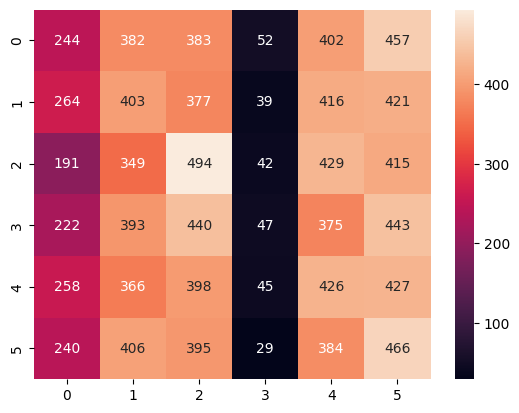

🏃 View run SVM LinearSVC at: https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow/#/experiments/19/runs/a44f919751f44fed82e4b18026bd9302
🧪 View experiment at: https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow/#/experiments/19


In [10]:
model_params = {
    'C': 10.0,
    # 'penalty': 'l2',
    'dual': False,
    'verbose': True,
    'max_iter': 1000
}

model = LinearSVC(**model_params).fit(X_train, y_train)
model = CalibratedClassifierCV(model, method='sigmoid', cv='prefit')
model.fit(X_calib, y_calib)

predict = model.predict(X_test)
predict_proba = model.predict_proba(X_test)

metrics = {
    'accuracy': accuracy_score(y_test, predict),
    'precision': precision_score(y_test, predict, average='macro'),
    'recall': recall_score(y_test, predict, average='macro'),
    'f1': f1_score(y_test, predict, average='macro'),
    'auc_score': roc_auc_score(y_test, predict_proba, multi_class='ovr', average='macro')
}

print(f"Accuracy: {metrics['accuracy']}\nPrecision: {metrics['precision']}\nRecall: {metrics['recall']}\nF1 Score: {metrics['f1']}\nAUC Score: {metrics['auc_score']}")
report = classification_report(y_test, predict)
print(report)

cm = confusion_matrix(y_test, predict)
sns.heatmap(cm, annot=True, fmt='d')
plt.savefig('confusion_matrix.png')
plt.show()

mlflow.set_experiment("SVM_Model FER2013 augmented")
mlflow.set_tracking_uri("https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow")

with mlflow.start_run(run_name=f'SVM LinearSVC'):
    mlflow.log_params(gabor_params)
    mlflow.log_params(model_params)
    mlflow.log_param('floating_point', FLOATING_POINT)
    mlflow.log_param('image_size', IMAGE_SIZE)
    mlflow.log_param('PCA_n_components', N_COMPONENTS)
    mlflow.log_param('gaussian_blur', BLUR)
    mlflow.log_metrics(metrics)
    mlflow.log_artifact('confusion_matrix.png')
    mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path='SVM Model',
        input_example=X_train[:1]
    )

In [ ]:
svc_model = SVC()

param_grid = {
    'C': [0.1, 1, 5, 10, 100],
}

grid_search = GridSearchCV(
    estimator=SVC(kernel='linear'),
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=2
)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
